Notebook used to produce figure 5 and data for figure 1. Trains and examines standard MNIST networks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as be

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [4]:
from baseline_models import *

In [5]:
limit_gpus()
set_gpu(1)

In [24]:
dpi=100

In [6]:
dataset = "mnist"
ds_train, ds_test, ds_info = load_dataset(dataset, 128)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

In [7]:
x_train, y_train = get_raw_dat(ds_train)

In [8]:
_, y_test = get_raw_dat(ds_test)

In [9]:
xs, ys = next(iter(ds_train))

In [10]:
input_shape

(28, 28, 1)

In [15]:
model = PhasorModel(input_shape, onehot_offset=0.0, onehot_phase=0.5, max_step=0.05, projection="NP")
model.compile(optimizer="rmsprop")

In [12]:
ys0 = model(xs)

(array([125., 150., 108., 124., 166., 147., 105., 108., 128., 119.]),
 array([-9.9880403e-01, -7.9893386e-01, -5.9906375e-01, -3.9919358e-01,
        -1.9932343e-01,  5.4672360e-04,  2.0041688e-01,  4.0028703e-01,
         6.0015720e-01,  8.0002731e-01,  9.9989748e-01], dtype=float32),
 <BarContainer object of 10 artists>)

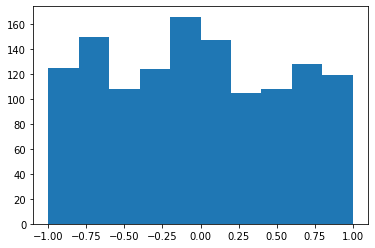

In [13]:
plt.hist(ys0.numpy().ravel())

In [16]:
loss = model.train(ds_train, 2)

Training loss tf.Tensor(1.1911367, shape=(), dtype=float32)
Training loss tf.Tensor(0.03942185, shape=(), dtype=float32)
Training loss tf.Tensor(0.033259436, shape=(), dtype=float32)
Training loss tf.Tensor(0.020004757, shape=(), dtype=float32)
Training loss tf.Tensor(0.024984565, shape=(), dtype=float32)
Training loss tf.Tensor(0.0214021, shape=(), dtype=float32)
Training loss tf.Tensor(0.014110388, shape=(), dtype=float32)
Training loss tf.Tensor(0.014367492, shape=(), dtype=float32)
Training loss tf.Tensor(0.018771078, shape=(), dtype=float32)
Training loss tf.Tensor(0.014319609, shape=(), dtype=float32)


In [17]:
yh1 = model(xs)

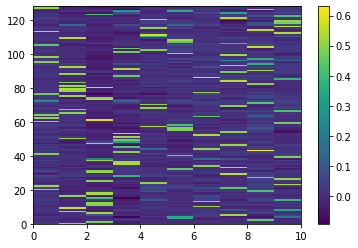

In [18]:
plt.pcolor(yh1)
plt.colorbar()

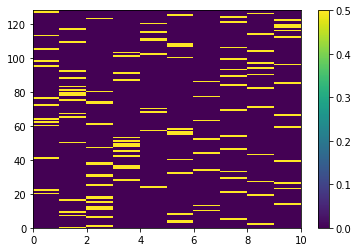

In [19]:
plt.pcolor(model.to_phase(ys))
plt.colorbar()

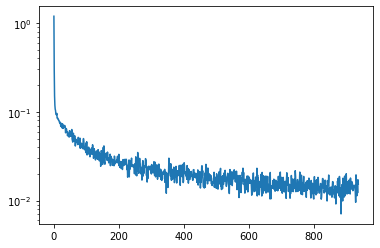

In [20]:
plt.semilogy(loss)

In [21]:
conf = model.accuracy(ds_test)

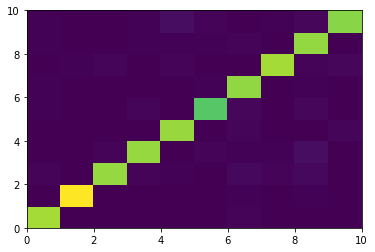

In [22]:
plt.pcolor(conf[0])

In [23]:
confusion_to_accuracy(conf)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9455>

Select a small sample of input images to dynamically execute in detail.

In [25]:
n_subsample = 10
small_test = tf.data.Dataset.from_tensor_slices((xs[0:n_subsample,...], ys[0:n_subsample,...]))
small_test = small_test.batch(n_subsample)

In [26]:
small_yhs = model.evaluate(small_test, method="dynamic")

100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


Calculate the matches between temporal predictions and ground truth.

In [28]:
model.predict(small_yhs, method="dynamic_mode").ravel() == ys[0:n_subsample,...]

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True])>

Show an input image and its corresponding spike train.

In [29]:
preprocess = keras.Sequential([model.layers[0]])

In [30]:
input_spikes = model.phase_to_train(model.image_encoder(preprocess(xs[0:n_subsample,...])))

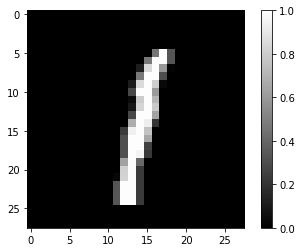

In [31]:
plt.imshow(xs[0,...], cmap="gray")
plt.colorbar()

Text(0.5, 1.0, 'Input Layer')

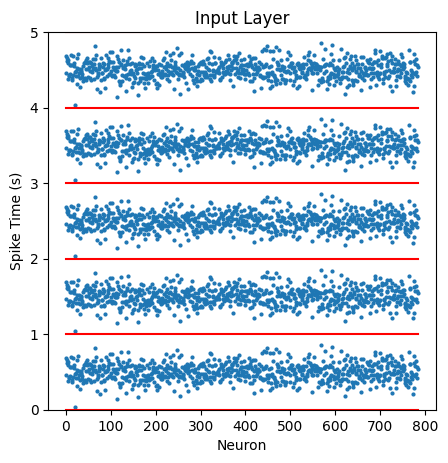

In [32]:
plt.figure(dpi=dpi, figsize=(5,5))
for i in range(10):
    plt.plot([0,784],[0.0+i,0+i], color="red")
plt.scatter(input_spikes[0][0], input_spikes[0][1], label="Input Spikes (Drive)", s=4)
#plt.scatter(dynamic_spikes[0][0], dynamic_spikes[0][1], label="Output Spikes (Response)")
#plt.xticks(lblinds, np.around(phases.ravel()[lblinds], decimals=2));

plt.xlabel("Neuron")
plt.ylabel("Spike Time (s)")
plt.ylim(0,5)
#plt.ylim(-0.5,10)
plt.title("Input Layer")

Show the spikes that arise in layer 1 as a response to the input spikes.

Text(0.5, 1.0, 'Dense 1')

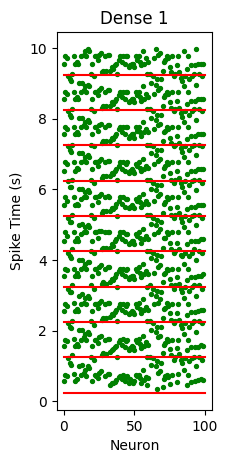

In [33]:
spk_layer1 = model.dense1.spike_trains
plt.figure(dpi=dpi, figsize=(2,5))
#plt.scatter(dynamic_input[0][0], dynamic_input[0][1], label="Input Spikes (Drive)")
for i in range(10):
    plt.plot([0,100],[0.25+i,0.25+i], color="red")
plt.scatter(spk_layer1[0][0], spk_layer1[0][1], label="Output Spikes (Response)", color="green", s=8)
#plt.xticks(lblinds, np.around(phases.ravel()[lblinds], decimals=2));
plt.xlabel("Neuron")
plt.ylabel("Spike Time (s)")
#plt.ylim(-0.5,10)
plt.title("Dense 1")

Show the spikes that arise in layer 2 (the output) as a response to layer 1 spikes.

In [34]:
spk_layer2 = model.dense2.spike_trains

Text(0.5, 1.0, 'Dense 2')

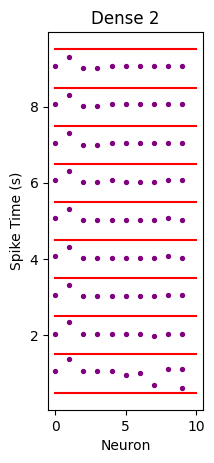

In [35]:
plt.figure(dpi=dpi, figsize=(2,5))
#plt.scatter(dynamic_input[0][0], dynamic_input[0][1], label="Input Spikes (Drive)")
for i in range(10):
    plt.plot([0,10],[0.50+i,0.50+i], color="red")
plt.scatter(spk_layer2[0][0], spk_layer2[0][1], label="Output Spikes (Response)", color="purple", s=8)
#plt.xticks(lblinds, np.around(phases.ravel()[lblinds], decimals=2));
plt.xlabel("Neuron")
plt.ylabel("Spike Time (s)")
#plt.ylim(-0.5,10)
plt.title("Dense 2")

Calculate accuracies using the mode of predicted phases for the small sample.

In [37]:
np.mean(model.predict(small_yhs, method="dynamic_mode").ravel() == ys[0:n_subsample])

0.9

Calculate the predicted phase values with temporal execution for all test images. This takes around 2.2s / image on the dev workstation but varies by CPU/GPU. 

In [33]:
all_yhs = model.evaluate(ds_test, method="dynamic")

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


In [34]:
all_yhs.shape

TensorShape([10000, 10, 10])

Save the results since they take a few hours to generate. 

In [37]:
np.savez_compressed("mnist_yhs_dynamic.npz", yhs=all_yhs.numpy(), ys=y_test)

In [40]:
np.mean(model.predict(all_yhs, method="dynamic_mode").ravel() == y_test)

0.9467

Convenience function to train and save MNIST phasor models easily. Used to generate series of networks for results in figure 1. 

In [44]:
def train_and_save(num):
    model = PhasorModel(input_shape, 
                    onehot_offset=0.0, 
                    onehot_phase=0.5,
                    projection="NP",
                   
                   exec_time=5.0,
                   repeats=5,
                   max_step=0.02)
    model.compile(optimizer="rmsprop")
    loss = model.train(ds_train, 2)
    
    yh_static = model.evaluate(ds_test, method="static")
    yh_dynamic = model.evaluate(ds_test, method="dynamic")
    
    name = "mnist_model_"+str(num)+".npz"
    np.savez_compressed(name, 
                        yh_static=yh_static.numpy(),
                        yh_dynamic=yh_dynamic.numpy(),
                        ys=y_test.numpy())

In [ ]:
for i in range(4):
    train_and_save(i)

Training loss tf.Tensor(0.7355691, shape=(), dtype=float32)
Training loss tf.Tensor(0.0414138, shape=(), dtype=float32)
Training loss tf.Tensor(0.02884664, shape=(), dtype=float32)
Training loss tf.Tensor(0.020415848, shape=(), dtype=float32)
Training loss tf.Tensor(0.01807487, shape=(), dtype=float32)
Training loss tf.Tensor(0.016070195, shape=(), dtype=float32)
Training loss tf.Tensor(0.02012305, shape=(), dtype=float32)
Training loss tf.Tensor(0.01105589, shape=(), dtype=float32)
Training loss tf.Tensor(0.014650123, shape=(), dtype=float32)
Training loss tf.Tensor(0.015350396, shape=(), dtype=float32)


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Training loss tf.Tensor(0.88640463, shape=(), dtype=float32)
Training loss tf.Tensor(0.036385942, shape=(), dtype=float32)
Training loss tf.Tensor(0.02726989, shape=(), dtype=float32)
Training loss tf.Tensor(0.028241556, shape=(), dtype=float32)
Training loss tf.Tensor(0.022143053, shape=(), dtype=float32)
Training loss tf.Tensor(0.016234966, shape=(), dtype=float32)
Training loss tf.Tensor(0.01915556, shape=(), dtype=float32)
Training loss tf.Tensor(0.015836399, shape=(), dtype=float32)
Training loss tf.Tensor(0.015480615, shape=(), dtype=float32)
Training loss tf.Tensor(0.012628876, shape=(), dtype=float32)


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


Training loss tf.Tensor(0.6623397, shape=(), dtype=float32)
Training loss tf.Tensor(0.035598926, shape=(), dtype=float32)
Training loss tf.Tensor(0.026972722, shape=(), dtype=float32)
Training loss tf.Tensor(0.01758653, shape=(), dtype=float32)
Training loss tf.Tensor(0.017735658, shape=(), dtype=float32)
Training loss tf.Tensor(0.01793126, shape=(), dtype=float32)
Training loss tf.Tensor(0.015347942, shape=(), dtype=float32)
Training loss tf.Tensor(0.015430205, shape=(), dtype=float32)
Training loss tf.Tensor(0.015016308, shape=(), dtype=float32)
Training loss tf.Tensor(0.010979011, shape=(), dtype=float32)


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


Training loss tf.Tensor(1.1045098, shape=(), dtype=float32)
Training loss tf.Tensor(0.041148685, shape=(), dtype=float32)
Training loss tf.Tensor(0.02673839, shape=(), dtype=float32)
Training loss tf.Tensor(0.023829194, shape=(), dtype=float32)
Training loss tf.Tensor(0.017580597, shape=(), dtype=float32)
Training loss tf.Tensor(0.0197622, shape=(), dtype=float32)
Training loss tf.Tensor(0.015742697, shape=(), dtype=float32)
Training loss tf.Tensor(0.020298526, shape=(), dtype=float32)
Training loss tf.Tensor(0.0152607, shape=(), dtype=float32)
Training loss tf.Tensor(0.011773767, shape=(), dtype=float32)


 95%|█████████▌| 122/128 [01:57<00:05,  1.03it/s]